In [1]:
import os
import tensorflow.compat.v1 as tf1

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2024-04-02 05:22:39.068071: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 05:22:39.162216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 05:22:41.205904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-02 05:22:45.641019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capabi

In [2]:
import os
import numpy as np
import random
import shutil

Non_data = "/MRI_치매_데이터생성/Non_train+VAE_Non_e5000_real-data-vector10000/"
Mild_data = "/MRI_치매_데이터생성터/Mild_train+VAE_Mild_e5000_real-data-vector10000/"

### 정상과 경증 증상 데이터 분할

In [3]:
# 정상과 경증 증상 데이터 분할

from sklearn.model_selection import train_test_split

def split_dataset(data, test_size=0.2):
    # 데이터를 train과 test로 분할합니다.
    X_train, X_test = train_test_split(data, test_size=test_size, random_state=42)
    return X_train, X_test

# "정상" 데이터
Non_train, Non_test = split_dataset(Non_data)

# "경증" 데이터
Mild_train, Mild_test = split_dataset(Mild_data)

### 1.Train data numpy array로 불러오기

In [4]:
import os
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# 이미지 파일 경로를 읽어오는 함수
def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 이미지를 넘파이 배열로 변환하는 함수
def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir = './MRI_치매_데이터생성/'
Non_image_paths = read_images_from_path(os.path.join(base_dir, "Non_train+GAE_Non_e5000_n10_real-data-vector3000"))
Mild_image_paths = read_images_from_path(os.path.join(base_dir, "Mild_train+GAE_Mild_e5000_n10_real-data-vector3000"))

# 각 카테고리별로 이미지 경로 리스트를 분할
Non_train_paths, Non_test_paths = train_test_split(Non_image_paths, test_size=0.2, random_state=42)
Mild_train_paths, Mild_test_paths = train_test_split(Mild_image_paths, test_size=0.2, random_state=42)

# 분할된 이미지 경로를 사용하여 넘파이 배열 생성
numpy_array_Non = images_to_numpy(Non_train_paths)
numpy_array_Mild = images_to_numpy(Mild_train_paths)

# 넘파이 배열의 크기 확인
print("정상 데이터 크기:", numpy_array_Non.shape)
print("경증 데이터 크기:", numpy_array_Mild.shape)


정상 데이터 크기: (4192, 128, 128)
경증 데이터 크기: (2901, 128, 128)


### 2.Train data의 label 원핫인코딩

In [5]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels.astype(int)]

# 각 클래스에 대한 레이블 생성
num_classes = 2  # 클래스 개수에 따라 조절
labels_Non = one_hot_encode(np.zeros(len(numpy_array_Non)), num_classes)
labels_Mild = one_hot_encode(np.ones(len(numpy_array_Mild)), num_classes)

# 데이터 확인
print("Moderate Demented Labels Shape:", labels_Non.shape)
print("Non Demented Labels Shape:", labels_Mild.shape)


# y 변수 생성
y_Non = labels_Non
y_Mild = labels_Mild

Moderate Demented Labels Shape: (4192, 2)
Non Demented Labels Shape: (2901, 2)


In [6]:
print(y_Non[:2])
print(y_Mild[:2])

[[1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]]


### 3. Train dataset 구축(Train data 3종류 합치고, shape 변경 및 셔플)

In [7]:
# Moderate_Demented, Non_Demented, Very_Mild_Demented 데이터 합치기
X_train = np.concatenate((numpy_array_Non, numpy_array_Mild), axis=0)

# 각 데이터에 대한 레이블 합치기
y_train = np.concatenate((y_Non, y_Mild), axis=0)

# 데이터와 레이블의 형태 확인
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

# 데이터와 레이블을 함께 섞기
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
X_train = np.reshape(X_train, (-1,128,128,1))
y_train = y_train[indices]

X_train = X_train / 255.

# 섞인 데이터와 레이블의 형태 확인
print("Shuffled X_train Shape:", X_train.shape)
print("Shuffled y_train Shape:", y_train.shape)

X_train Shape: (7093, 128, 128)
y_train Shape: (7093, 2)
Shuffled X_train Shape: (7093, 128, 128, 1)
Shuffled y_train Shape: (7093, 2)


### 4. Train dataset 이미지로 시각화 해보기

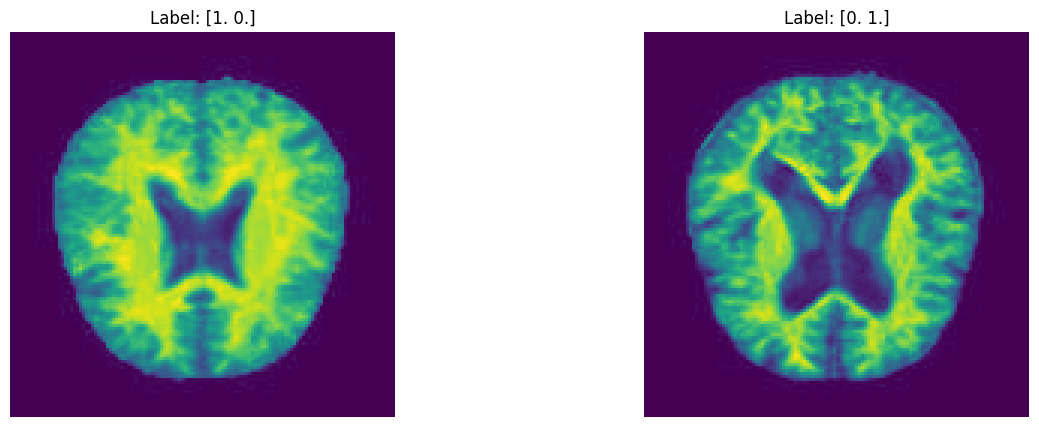

In [8]:
import matplotlib.pyplot as plt
# 원하는 레이블에 해당하는 이미지 무작위로 선택
desired_labels = np.array([[1, 0], [0, 1]])
selected_images = []
selected_labels = []

for label in desired_labels:
    # 해당 레이블에 해당하는 인덱스 추출
    indices = np.where((y_train == label).all(axis=1))[0]
    
    # 해당 인덱스 중 무작위로 1개 선택
    random_index = np.random.choice(indices, 1)[0]
    
    # 이미지 및 레이블 저장
    selected_images.append(X_train[random_index])
    selected_labels.append(y_train[random_index])

# 선택한 이미지 플로팅
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axes[i].imshow(selected_images[i])
    axes[i].set_title(f"Label: {selected_labels[i]}")
    axes[i].axis('off')

plt.show()


In [9]:
print(np.max(X_train[0]), np.min(X_train[0]))

0.9333333333333333 0.0


### 5. 모델 학습

2024-04-02 05:22:50.954351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

2024-04-02 05:22:57.589477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-02 05:22:58.953527: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-02 05:22:59.166893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-02 05:22:59.171198: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2e380083c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-02 05:22:59.171264: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-04-02 05:22:59.182125: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-02 05:22:59.345136:

178/178 [==============================] - 12s 17ms/step - loss: 0.2057 - accuracy: 0.9069 - val_loss: 0.2004 - val_accuracy: 0.9246
Epoch 2/15
178/178 [==============================] - 2s 10ms/step - loss: 0.1255 - accuracy: 0.9432 - val_loss: 0.1110 - val_accuracy: 0.9479
Epoch 3/15
178/178 [==============================] - 2s 10ms/step - loss: 0.0929 - accuracy: 0.9588 - val_loss: 0.0932 - val_accuracy: 0.9648
Epoch 4/15
178/178 [==============================] - 2s 10ms/step - loss: 0.0605 - accuracy: 0.9767 - val_loss: 0.0815 - val_accuracy: 0.9612
Epoch 5/15
178/178 [==============================] - 2s 11ms/step - loss: 0.0362 - accuracy: 0.9863 - val_loss: 0.0527 - val_accuracy: 0.9810
Epoch 6/15
178/178 [==============================] - 2s 12ms/step - loss: 0.0177 - accuracy: 0.9942 - val_loss: 0.0490 - val_accuracy: 0.9838
Epoch 7/15
178/178 [==============================] - 2s 11ms/step - loss: 0.0181 - accuracy: 0.9931 - val_loss: 0.0373 - val_accuracy: 0.9852
Epoch 8/1

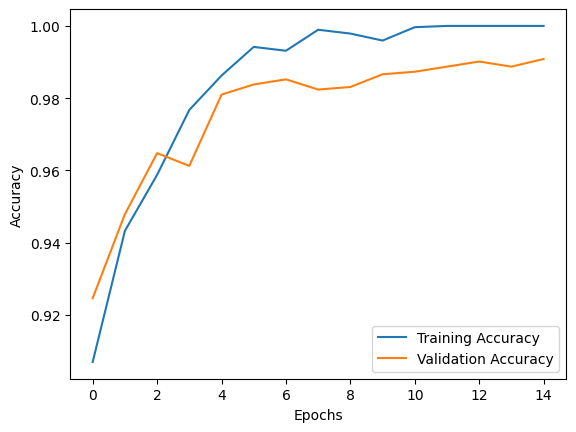

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# CNN 모델 정의
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))  # 3은 클래스의 개수에 따라 조절

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())
# 데이터 학습
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# loss: 2.0572e-05 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9901

### 학습한 모델에 Train data에 대해 Confusion matrix와 F1-Score 출력하기

222/222 [==============================] - 1s 5ms/step


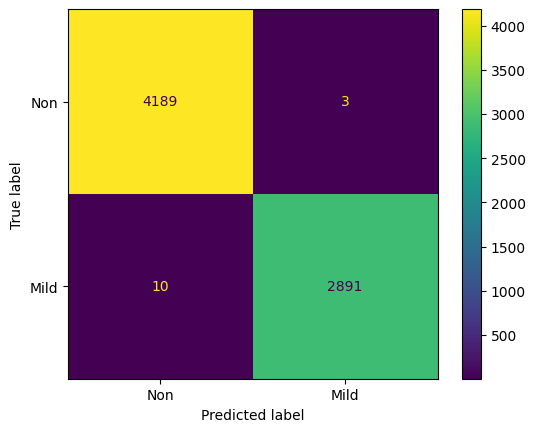

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_train = model.predict(X_train)

# Confusion Matrix 계산
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(y_pred_train, axis=1))

# Confusion Matrix 시각화
labels = ["Non", "Mild"]
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap='viridis', values_format='d')
plt.show()

In [13]:
from sklearn.metrics import f1_score

y_pred_labels = np.argmax(y_pred_train, axis=1)
y_true_labels = np.argmax(y_train, axis=1)

# F1 Score 계산
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print(f"F1 Score: {f1}")


F1 Score: 0.9981668646384124


# 
### Test data 불러오기

In [14]:
import matplotlib.image as mpimg

# 이미지 파일 경로를 읽어오는 함수
def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 이미지를 넘파이 배열로 변환하는 함수
def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir = 'MRI_치매_데이터__/'
Non_image_paths = read_images_from_path(os.path.join(base_dir, "Non_Demented_test"))
Mild_image_paths = read_images_from_path(os.path.join(base_dir, "Mild_Demented_test"))

# 각 카테고리별로 이미지 경로 리스트를 분할
Non_train_paths, normal_test_paths = train_test_split(Non_image_paths, test_size=0.2, random_state=42)
Mild_train_paths, Non_normal_test_paths = train_test_split(Mild_image_paths, test_size=0.2, random_state=42)

# 분할된 이미지 경로를 사용하여 넘파이 배열 생성
numpy_array_Non = images_to_numpy(Non_train_paths)
numpy_array_Mild = images_to_numpy(Mild_train_paths)

# 넘파이 배열의 크기 확인
print("정상 데이터 크기:", numpy_array_Non.shape)
print("경증 데이터 크기:", numpy_array_Mild.shape)


정상 데이터 크기: (768, 128, 128)
경증 데이터 크기: (215, 128, 128)


In [15]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels.astype(int)]

# 각 클래스에 대한 레이블 생성
num_classes = 2  # 클래스 개수에 따라 조절
labels_Non = one_hot_encode(np.zeros(len(numpy_array_Non)), num_classes)
labels_Mild = one_hot_encode(np.ones(len(numpy_array_Mild)), num_classes)

# 데이터 확인
print("Non Demented Labels Shape:", labels_Non.shape)
print("Mild Demented Labels Shape:", labels_Mild.shape)


# y 변수 생성
y_Non = labels_Non
y_Mild = labels_Mild

Non Demented Labels Shape: (768, 2)
Mild Demented Labels Shape: (215, 2)


In [16]:

# Moderate_Demented, Non_Demented, Very_Mild_Demented 데이터 합치기
X_test = np.concatenate((numpy_array_Non, numpy_array_Mild), axis=0)

# 각 데이터에 대한 레이블 합치기
y_test = np.concatenate((y_Non, y_Mild), axis=0)

# 데이터와 레이블의 형태 확인
print("X_train Shape:", X_test.shape)
print("y_train Shape:", y_test.shape)

# 데이터와 레이블을 함께 섞기
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)

X_test = X_test[indices]
X_test = np.reshape(X_test, (-1,128,128,1))
X_test = X_test / 255.
y_test = y_test[indices]

# 섞인 데이터와 레이블의 형태 확인
print("Shuffled X_test Shape:", X_test.shape)
print("Shuffled y_test Shape:", y_test.shape)

X_train Shape: (983, 128, 128)
y_train Shape: (983, 2)
Shuffled X_test Shape: (983, 128, 128, 1)
Shuffled y_test Shape: (983, 2)


31/31 [==============================] - 0s 8ms/step


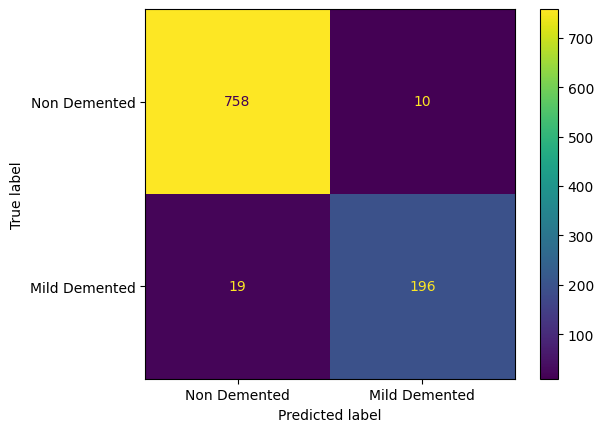

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 테스트 데이터 예측
y_pred_test = model.predict(X_test)

# Confusion Matrix 계산
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_test, axis=1))

# Confusion Matrix 시각화
labels = ["Non Demented","Mild Demented"]
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap='viridis', values_format='d')
plt.show()

In [18]:
from sklearn.metrics import f1_score

# 테스트 데이터에 대한 예측값에서 가장 높은 확률의 클래스를 추출
y_pred_test_labels = np.argmax(y_pred_test, axis=1)
y_true_test_labels = np.argmax(y_test, axis=1)

# F1 Score 계산
f1 = f1_score(y_true_test_labels, y_pred_test_labels, average='weighted')

print(f"F1 Score: {f1}")


F1 Score: 0.9702690638579722
